In [3]:
# 📊 Data Handling
import pandas as pd
import numpy as np

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ⚙️ Preprocessing & Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 📈 Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats

# 🧠 Modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import keras_tuner as kt

In [4]:
from google.colab import files
uploaded = files.upload()


df = pd.read_csv('my_tvl_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)
df = df[['tvl_usd']]


Saving my_tvl_data.csv to my_tvl_data.csv


# 01.  🧹 Data Cleaning


In [5]:
#Check Missing variables
df.index.to_series().diff().value_counts()

,count
date,
1 days 00:00:00,364
0 days 16:51:47,1


In [6]:
#Check Outliers
fig = px.box(df, y='tvl_usd', title='Box plot of TVL' , labels={"tvl_usd": "TVL (USD)"})
fig.show()

# 02. Pre-modeling Analysis


In [7]:
# Look at trend line
data = df.groupby(['date'])['tvl_usd'].sum().reset_index()

fig1 = px.line(
    data,
    x='date',
    y='tvl_usd',
    title="Daily TVL USD on Ethereum Protocol Aave",
    labels={
        "date": "Date",
        "tvl_usd": "TVL (USD)"}
)

fig1.update_layout(
    xaxis_title="Date",
    yaxis_title="TVL (USD)")

fig1.show()

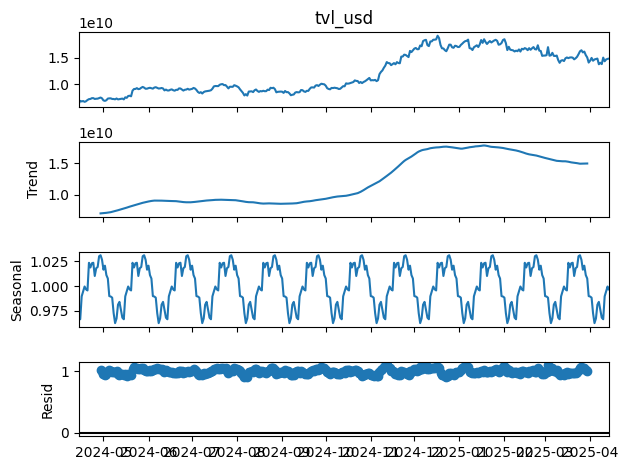

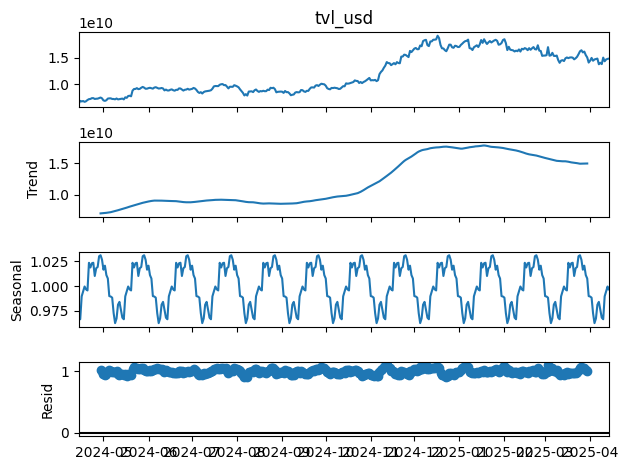

In [15]:
# decomposition
decomposition = seasonal_decompose(df['tvl_usd'], model= 'multiplicative' , period=30)
decomposition.plot()

In [16]:
seasonal = decomposition.seasonal
seasonal_range = round(seasonal.max() - seasonal.min(),2)
seasonal_strength = seasonal_range / seasonal.mean()
print(f"Seasonal range: {seasonal_range}")
print(f"Seasonality strength (as %): {seasonal_strength * 100:.2f}%")

Seasonal range: 0.07
Seasonality strength (as %): 7.00%


In [17]:
# Check stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['tvl_usd'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.255558574082033
p-value: 0.6492513244349408


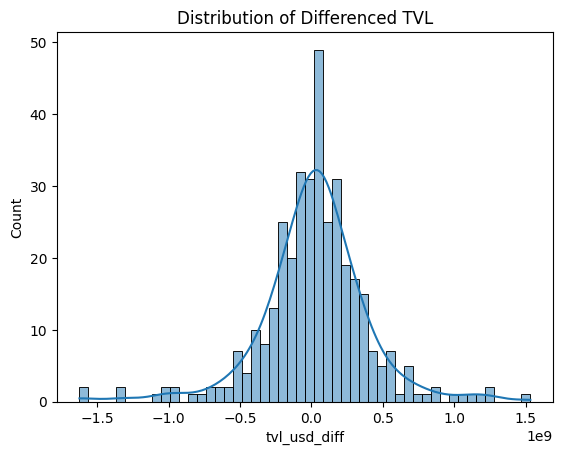

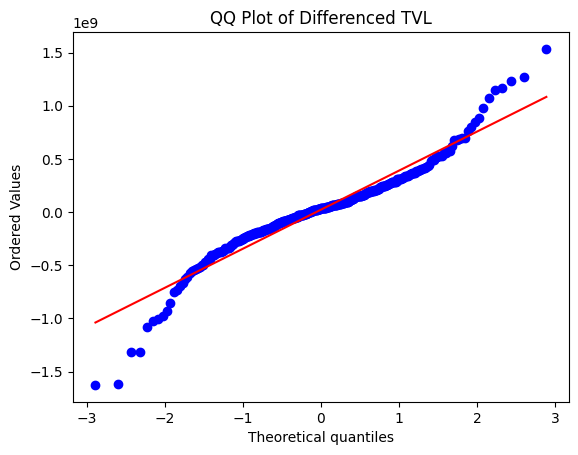

In [45]:
# df['log_tvl'] = np.log(df['tvl_usd'] + 1)
#df['log_diff'] = df['log_tvl'].diff().dropna()
diffs = df['tvl_usd'].diff().dropna()

# diff histogram
fig4 = px.histogram(
    x=diffs,
    nbins=30,
    title="Histogram of TVL Daily Differences",
    labels={"x": "Daily TVL Change (USD)"},
)
fig4.update_layout(bargap=0.1)
fig4.show()


##  diff histogram
sns.histplot(diffs, bins=50, kde=True)
plt.title("Distribution of Differenced TVL")
plt.xlabel("tvl_usd_diff")
plt.show()

## QQ plot
stats.probplot(diffs, dist="norm", plot=plt)
plt.title("QQ Plot of Differenced TVL")
plt.show()

In [46]:
# check stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(diffs.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -20.390355528435542
p-value: 0.0


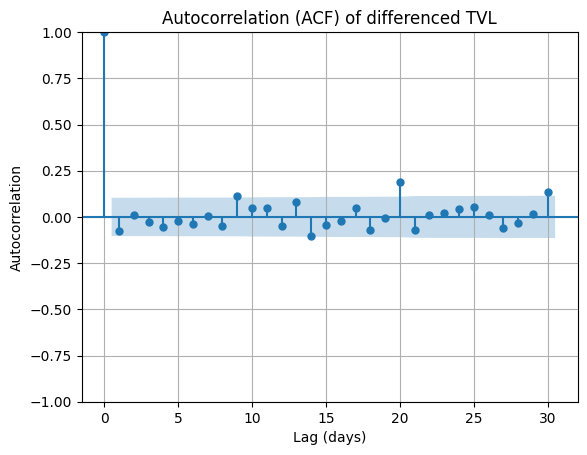

In [47]:
# check self correlation
plot_acf(diffs, lags=30)
plt.title("Autocorrelation (ACF) of differenced TVL")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

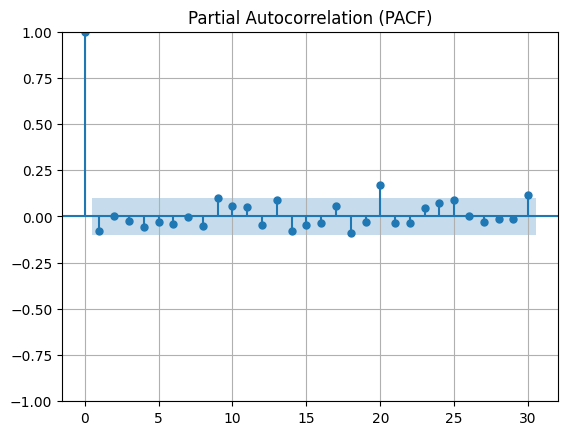

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diffs, lags=30)
plt.title("Partial Autocorrelation (PACF)")
plt.grid(True)
plt.show()

# 03. Manipulating Data

In [48]:
# Feature engineering
df['tvl_ma7'] = df['tvl_usd'].rolling(window=7).mean()
df['tvl_diff'] = df['tvl_usd'].diff()
df.dropna(inplace=True)
df.head()

,tvl_usd,tvl_ma7,tvl_diff
date,,,
2024-04-26,7.203924e+09,7.176927e+09,4.279007e+07
2024-04-27,7.219891e+09,7.213800e+09,1.596662e+07
2024-04-28,7.337787e+09,7.244332e+09,1.178961e+08
2024-04-29,7.434260e+09,7.283380e+09,9.647301e+07
2024-04-30,7.273635e+09,7.278319e+09,-1.606251e+08


In [60]:
# Train|Test Split
test_days = 60
train_df = df.iloc[:-test_days]
test_df = df.iloc[-test_days:]


# Normalization
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# window
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])
    return np.array(X), np.array(y)

window_size = 30
X_all, y_all = create_sequences(scaled, window=window_size)


test_days = 60
X_train, y_train = X_all[:-test_days], y_all[:-test_days]
X_test, y_test = X_all[-test_days:], y_all[-test_days:]

# 04. Hyperparameter Tests

In [31]:
# define LSTM model with different hyperparameters

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Choice('units', [32, 64, 128]),
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0005])
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

In [42]:
# deploy KerasTuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='tvl_forecast'
)

tuner.search(X_train, y_train,
             epochs=50,
             validation_split=0.2,
             batch_size=32,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Trial 20 Complete [00h 00m 05s]
val_loss: 0.002602124586701393

Best val_loss So Far: 0.0014908822486177087
Total elapsed time: 00h 43m 31s


In [43]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Parameters:")
print(f"units: {best_hps.get('units')}")
print(f"dropout: {best_hps.get('dropout')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

Best Parameters:
units: 128
dropout: 0.5
learning_rate: 0.01


# 05. Build the Model

In [61]:
# build the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, X_all.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mae')

Dropout(0.3)
LSTM(64)
Dense(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [62]:
# train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.1884 - val_loss: 0.0854
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0805 - val_loss: 0.0601
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0590 - val_loss: 0.0719
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0583 - val_loss: 0.2164
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0586 - val_loss: 0.0557
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0577 - val_loss: 0.0773
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0578 - val_loss: 0.1218
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0525 - val_loss: 0.0502
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0549 - val_loss: 0.0700
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0538 - val_loss: 0.0464
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0477 - val_loss: 0.1316
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

In [63]:
y_pred = model.predict(X_test)

tvl_scaler = MinMaxScaler()
tvl_scaler.min_, tvl_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_test_inv = tvl_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = tvl_scaler.inverse_transform(y_pred)

dates_test = df.index[-test_days:]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


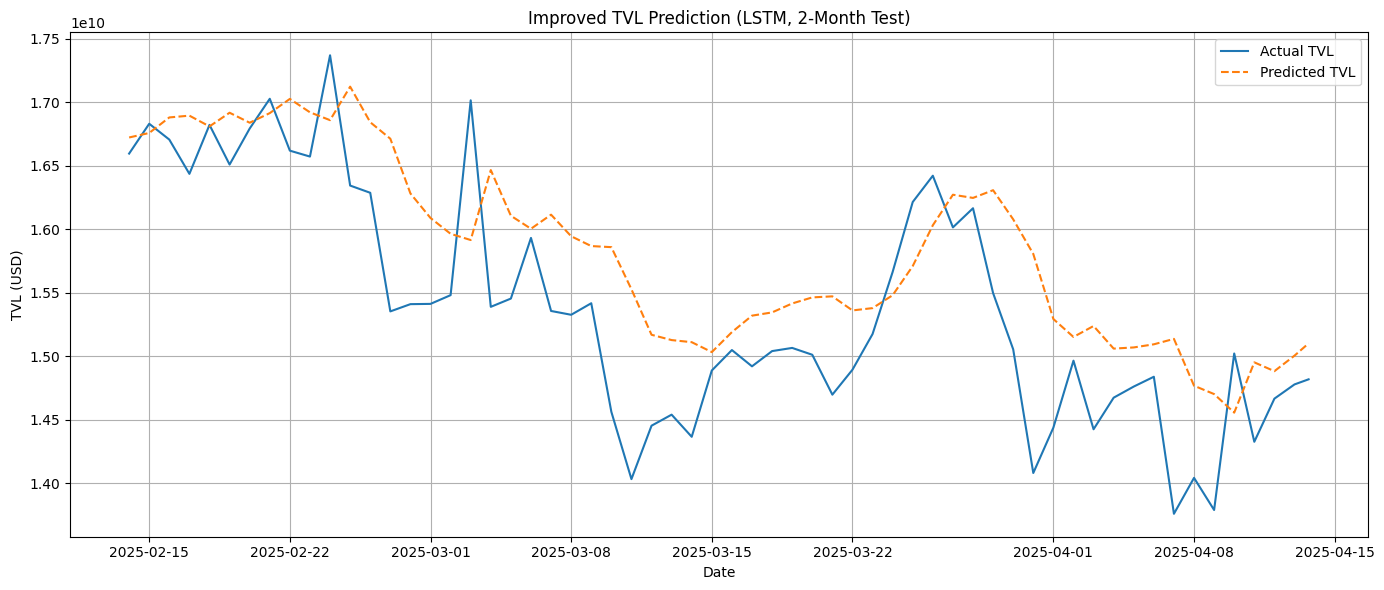

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_inv, label='Actual TVL')
plt.plot(dates_test, y_pred_inv, label='Predicted TVL', linestyle='--')
plt.title('Improved TVL Prediction (LSTM, 2-Month Test)')
plt.xlabel('Date')
plt.ylabel('TVL (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [65]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,996 (394.52 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,499 (197.27 KB)

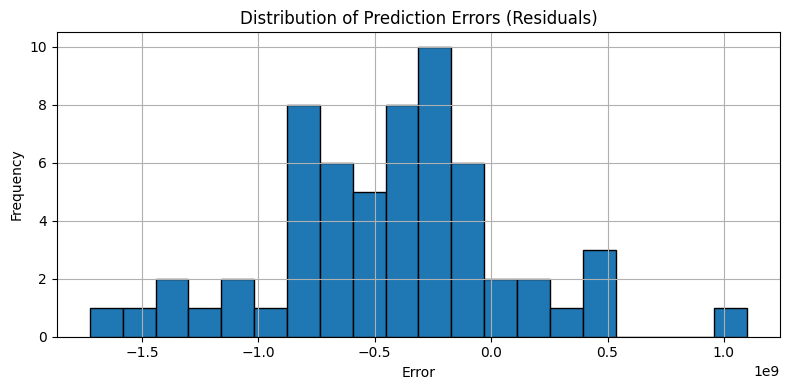

In [102]:
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

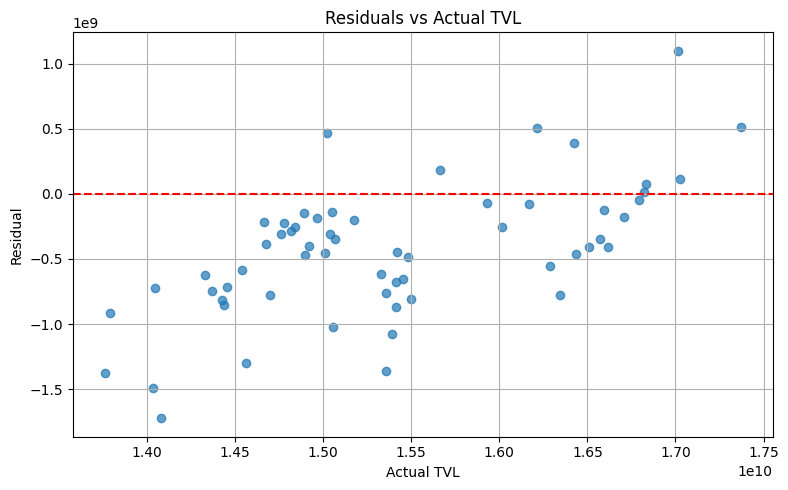

In [103]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_inv, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual TVL')
plt.ylabel('Residual')
plt.title('Residuals vs Actual TVL')
plt.grid(True)
plt.tight_layout()
plt.show()

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mean_tvl = np.mean(y_test_inv)
mae_pct = mae / mean_tvl * 100
rmse_pct = rmse / mean_tvl * 100

print(f" MAE ≈ {mae_pct:.2f}% of average TVL")
print(f"RMSE ≈ {rmse_pct:.2f}% of average TVL")

 MAE ≈ 3.55% of average TVL
RMSE ≈ 4.35% of average TVL


# End